# Data Cleaning

This notebook focuses on cleaning the Ames Housing dataset based on findings from the data exploration.

## What we will do:
1. Handle missing values systematically
2. Detect and handle outliers
3. Clean categorical variables
4. Feature engineering for missing data
5. Save cleaned dataset


In [30]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)


## 1. Load Data


In [ ]:
# Load the dataset
df = pd.read_csv('../../data/raw/raw.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Total missing values: {df.isnull().sum().sum()}")


Original dataset shape: (1460, 81)
Total missing values: 7829


## 2. Missing Values Analysis and Handling

Based on exploration, we identified several columns with missing values. We'll handle them based on domain knowledge.


In [32]:
# Get missing values summary
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing_Count': missing_values,
    'Missing_Percent': missing_percent
})

missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]
missing_summary = missing_summary.sort_values('Missing_Percent', ascending=False)

print("Missing values summary:")
print(missing_summary)


Missing values summary:
              Missing_Count  Missing_Percent
PoolQC                 1453        99.520548
MiscFeature            1406        96.301370
Alley                  1369        93.767123
Fence                  1179        80.753425
MasVnrType              872        59.726027
FireplaceQu             690        47.260274
LotFrontage             259        17.739726
GarageType               81         5.547945
GarageYrBlt              81         5.547945
GarageFinish             81         5.547945
GarageQual               81         5.547945
GarageCond               81         5.547945
BsmtExposure             38         2.602740
BsmtFinType2             38         2.602740
BsmtQual                 37         2.534247
BsmtCond                 37         2.534247
BsmtFinType1             37         2.534247
MasVnrArea                8         0.547945
Electrical                1         0.068493


### 2.1 Handle columns with very high missing percentages (>80%)


In [33]:
# Columns with >80% missing values - these typically mean "None" or "Not Available"
high_missing_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']

for col in high_missing_cols:
    if col in df.columns:
        # Fill with 'None' to indicate absence of feature
        df[col] = df[col].fillna('None')
        print(f"Filled {col} missing values with 'None'")

print(f"\nMissing values after handling high missing columns: {df.isnull().sum().sum()}")


Filled PoolQC missing values with 'None'
Filled MiscFeature missing values with 'None'
Filled Alley missing values with 'None'
Filled Fence missing values with 'None'

Missing values after handling high missing columns: 2422


### 2.2 Handle basement-related missing values


In [34]:
# Basement columns - missing likely means no basement
basement_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for col in basement_cols:
    if col in df.columns:
        df[col] = df[col].fillna('None')
        print(f"Filled {col} missing values with 'None'")

print(f"\nMissing values after handling basement columns: {df.isnull().sum().sum()}")


Filled BsmtQual missing values with 'None'
Filled BsmtCond missing values with 'None'
Filled BsmtExposure missing values with 'None'
Filled BsmtFinType1 missing values with 'None'
Filled BsmtFinType2 missing values with 'None'

Missing values after handling basement columns: 2235


### 2.3 Handle garage-related missing values


In [35]:
# Garage columns - missing likely means no garage
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

for col in garage_cols:
    if col in df.columns:
        df[col] = df[col].fillna('None')
        print(f"Filled {col} missing values with 'None'")

# GarageYrBlt - fill with 0 to indicate no garage
if 'GarageYrBlt' in df.columns:
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
    print("Filled GarageYrBlt missing values with 0")

print(f"\nMissing values after handling garage columns: {df.isnull().sum().sum()}")


Filled GarageType missing values with 'None'
Filled GarageFinish missing values with 'None'
Filled GarageQual missing values with 'None'
Filled GarageCond missing values with 'None'
Filled GarageYrBlt missing values with 0

Missing values after handling garage columns: 1830


### 2.4 Handle fireplace and masonry veneer missing values


In [36]:
# FireplaceQu - missing means no fireplace
if 'FireplaceQu' in df.columns:
    df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
    print("Filled FireplaceQu missing values with 'None'")

# MasVnrType and MasVnrArea - missing likely means no masonry veneer
if 'MasVnrType' in df.columns:
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    print("Filled MasVnrType missing values with 'None'")

if 'MasVnrArea' in df.columns:
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
    print("Filled MasVnrArea missing values with 0")

print(f"\nMissing values after handling fireplace and masonry columns: {df.isnull().sum().sum()}")


Filled FireplaceQu missing values with 'None'
Filled MasVnrType missing values with 'None'
Filled MasVnrArea missing values with 0

Missing values after handling fireplace and masonry columns: 260


### 2.5 Handle remaining missing values


In [37]:
# LotFrontage - fill with median by neighborhood
if 'LotFrontage' in df.columns:
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median())
    )
    print("Filled LotFrontage missing values with neighborhood median")

# Electrical - fill with mode (most common value)
if 'Electrical' in df.columns:
    mode_electrical = df['Electrical'].mode()[0]
    df['Electrical'] = df['Electrical'].fillna(mode_electrical)
    print(f"Filled Electrical missing values with mode: {mode_electrical}")

print(f"\nFinal missing values count: {df.isnull().sum().sum()}")


Filled LotFrontage missing values with neighborhood median
Filled Electrical missing values with mode: SBrkr

Final missing values count: 0


## 3. Outlier Detection and Handling


In [38]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers.index.tolist()

# Detect outliers in important columns
important_cols = ['GrLivArea', 'LotArea', 'TotalBsmtSF', 'SalePrice']
outlier_summary = {}

for col in important_cols:
    if col in df.columns:
        outliers = detect_outliers_iqr(df, col)
        outlier_summary[col] = len(outliers)
        print(f"{col}: {len(outliers)} outliers detected")

print(f"\nTotal outlier summary: {outlier_summary}")


GrLivArea: 31 outliers detected
LotArea: 69 outliers detected
TotalBsmtSF: 61 outliers detected
SalePrice: 61 outliers detected

Total outlier summary: {'GrLivArea': 31, 'LotArea': 69, 'TotalBsmtSF': 61, 'SalePrice': 61}


In [39]:
# Apply statistical outlier removal using modified IQR method
print("Applying statistical outlier removal...")
print("Using conservative approach: removing only extreme outliers (Q1-3*IQR, Q3+3*IQR)")

initial_shape = df.shape[0]
outliers_removed_summary = {}

# Define columns for outlier removal
outlier_cols = ['GrLivArea', 'LotArea', 'TotalBsmtSF', 'SalePrice']

for col in outlier_cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Conservative bounds: Q1-3*IQR and Q3+3*IQR (removes only extreme outliers)
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        # Identify outliers
        outliers_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outliers_count = outliers_mask.sum()
        
        if outliers_count > 0:
            print(f"\n{col}:")
            print(f"  Bounds: [{lower_bound:.0f}, {upper_bound:.0f}]")
            print(f"  Found {outliers_count} extreme outliers")
            
            # Remove outliers
            df = df[~outliers_mask]
            outliers_removed_summary[col] = outliers_count

final_shape = df.shape[0]
total_removed = initial_shape - final_shape

print(f"\n=== OUTLIER REMOVAL SUMMARY ===")
print(f"Initial dataset: {initial_shape} rows")
print(f"Final dataset: {final_shape} rows") 
print(f"Total outliers removed: {total_removed}")
if outliers_removed_summary:
    print("Outliers removed by column:")
    for col, count in outliers_removed_summary.items():
        print(f"  {col}: {count}")

Applying statistical outlier removal...
Using conservative approach: removing only extreme outliers (Q1-3*IQR, Q3+3*IQR)

GrLivArea:
  Bounds: [-812, 3718]
  Found 4 extreme outliers

LotArea:
  Bounds: [-4609, 23736]
  Found 32 extreme outliers

TotalBsmtSF:
  Bounds: [-656, 2725]
  Found 3 extreme outliers

SalePrice:
  Bounds: [-117000, 457000]
  Found 8 extreme outliers

=== OUTLIER REMOVAL SUMMARY ===
Initial dataset: 1460 rows
Final dataset: 1413 rows
Total outliers removed: 47
Outliers removed by column:
  GrLivArea: 4
  LotArea: 32
  TotalBsmtSF: 3
  SalePrice: 8


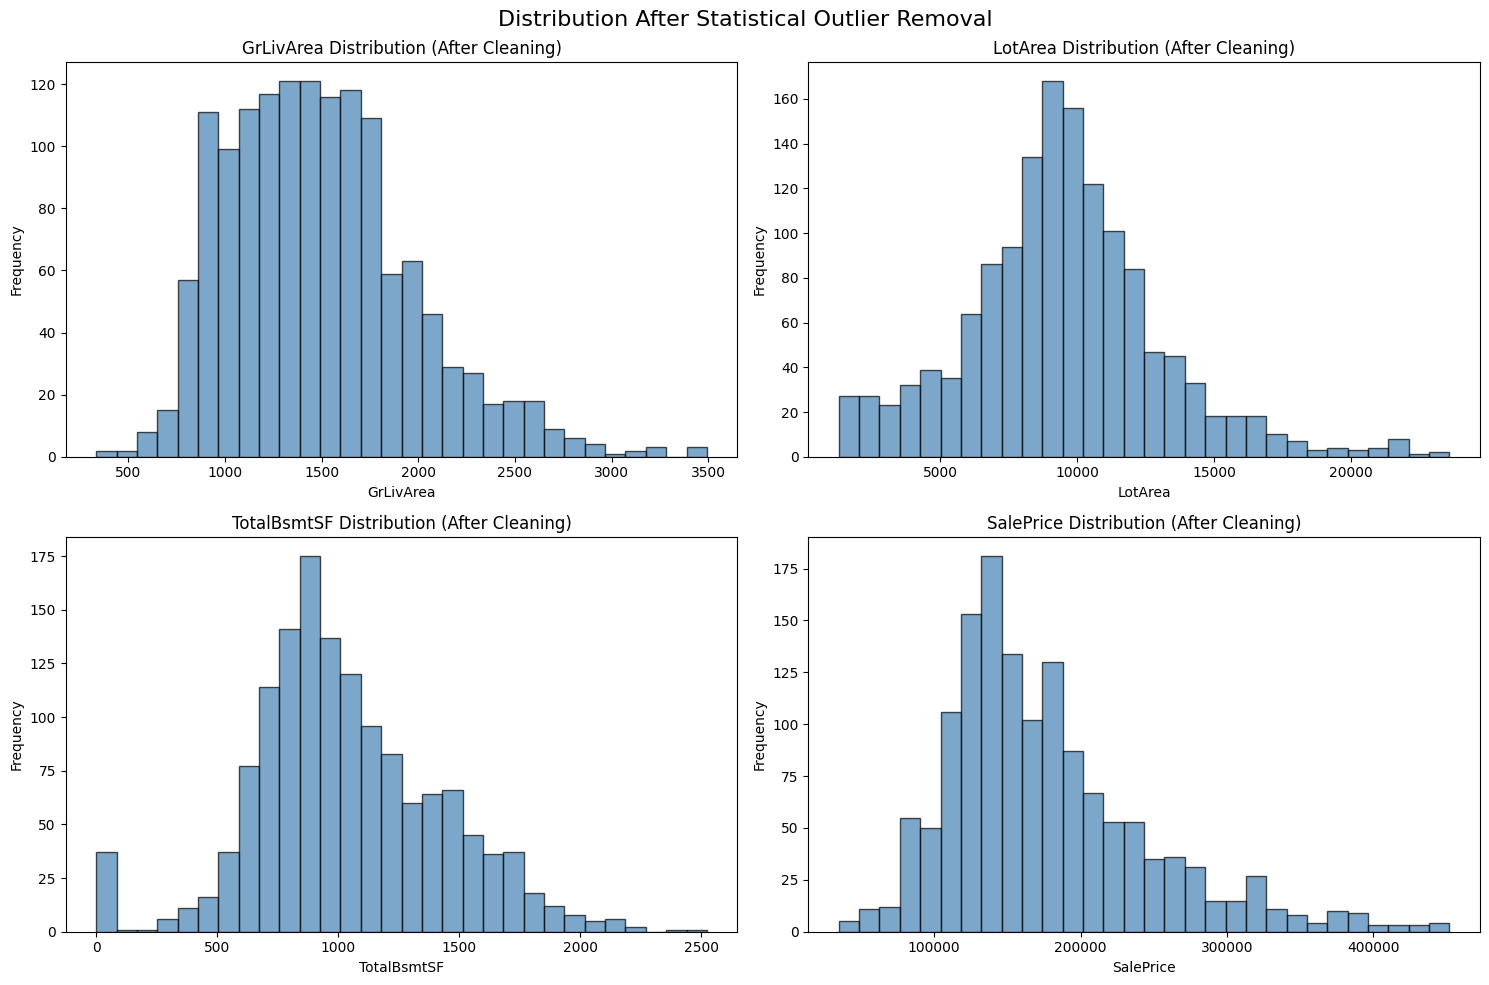


=== POST-OUTLIER REMOVAL STATISTICS ===

GrLivArea:
  Mean: 1487.91
  Median: 1445.00
  Std: 479.00
  Min: 334.00
  Max: 3493.00

LotArea:
  Mean: 9466.88
  Median: 9337.00
  Std: 3555.39
  Min: 1300.00
  Max: 23595.00

TotalBsmtSF:
  Mean: 1034.10
  Median: 980.00
  Std: 392.29
  Min: 0.00
  Max: 2524.00

SalePrice:
  Mean: 176130.48
  Median: 160000.00
  Std: 69518.74
  Min: 34900.00
  Max: 451950.00


In [40]:
# Visualize outlier removal impact
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution After Statistical Outlier Removal', fontsize=16)

# Plot distributions for key numeric columns
numeric_cols = ['GrLivArea', 'LotArea', 'TotalBsmtSF', 'SalePrice']

for i, col in enumerate(numeric_cols):
    if col in df.columns:
        row = i // 2
        col_idx = i % 2
        
        # Histogram
        axes[row, col_idx].hist(df[col], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
        axes[row, col_idx].set_title(f'{col} Distribution (After Cleaning)')
        axes[row, col_idx].set_xlabel(col)
        axes[row, col_idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print some basic statistics after outlier removal
print("\n=== POST-OUTLIER REMOVAL STATISTICS ===")
for col in numeric_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"  Mean: {df[col].mean():.2f}")
        print(f"  Median: {df[col].median():.2f}")
        print(f"  Std: {df[col].std():.2f}")
        print(f"  Min: {df[col].min():.2f}")
        print(f"  Max: {df[col].max():.2f}")


In [41]:
# Additional domain-specific outlier checks
print("Applying domain-specific outlier checks...")

domain_outliers_removed = 0
initial_domain_shape = df.shape[0]

# 1. Unrealistic lot sizes (too large)
if 'LotArea' in df.columns:
    unrealistic_lots = df[df['LotArea'] > 100000]  # > 2.3 acres is very unusual
    if len(unrealistic_lots) > 0:
        print(f"Found {len(unrealistic_lots)} houses with unrealistically large lots (>100,000 sq ft)")
        df = df[df['LotArea'] <= 100000]
        domain_outliers_removed += len(unrealistic_lots)

# 2. Extreme price outliers (based on domain knowledge)
if 'SalePrice' in df.columns:
    price_outliers = df[(df['SalePrice'] < 50000) | (df['SalePrice'] > 800000)]
    if len(price_outliers) > 0:
        print(f"Found {len(price_outliers)} houses with extreme prices (<$50k or >$800k)")
        df = df[(df['SalePrice'] >= 50000) & (df['SalePrice'] <= 800000)]
        domain_outliers_removed += len(price_outliers)

# 3. Houses with disproportionate living area to price ratio
if 'GrLivArea' in df.columns and 'SalePrice' in df.columns:
    # Large houses with very low prices (likely partial sales or data errors)
    disproportionate = df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)]
    if len(disproportionate) > 0:
        print(f"Found {len(disproportionate)} houses with disproportionate size/price ratio")
        print("Details of disproportionate houses:")
        print(disproportionate[['GrLivArea', 'SalePrice']].to_string())
        df = df.drop(disproportionate.index)
        domain_outliers_removed += len(disproportionate)

final_domain_shape = df.shape[0]
print(f"\n=== DOMAIN-SPECIFIC OUTLIER REMOVAL ===")
print(f"Additional outliers removed: {domain_outliers_removed}")
print(f"Dataset shape after all outlier removal: {df.shape}")
print(f"Total rows removed in this step: {initial_domain_shape - final_domain_shape}")


Applying domain-specific outlier checks...
Found 5 houses with extreme prices (<$50k or >$800k)

=== DOMAIN-SPECIFIC OUTLIER REMOVAL ===
Additional outliers removed: 5
Dataset shape after all outlier removal: (1408, 81)
Total rows removed in this step: 5


## Outlier Removal Strategy

We applied a two-step outlier removal approach:

### 1. Statistical Outlier Removal
- **Method**: Conservative IQR approach (Q1-3×IQR, Q3+3×IQR)
- **Rationale**: Removes only extreme statistical outliers while preserving data integrity
- **Target columns**: GrLivArea, LotArea, TotalBsmtSF, SalePrice

### 2. Domain-Specific Outlier Removal  
- **Unrealistic lot sizes**: >100,000 sq ft (>2.3 acres)
- **Extreme prices**: <$50,000 or >$800,000
- **Disproportionate houses**: Large living area (>4,000 sq ft) with very low price (<$300,000)

### Result
The combination of statistical and domain-specific approaches ensures we remove genuine outliers that could negatively impact model performance while retaining valuable data points that represent legitimate market variations.  

## 4. Data Type Optimization


In [42]:
print("Converting numeric columns to category if they represent categories:")
categorical_numeric = {
    'MSSubClass': 'category',
    'OverallQual': 'category', 
    'OverallCond': 'category',
    'MoSold': 'category'
}

converted_cols = []
for col, dtype in categorical_numeric.items():
    if col in df.columns:
        df[col] = df[col].astype(dtype)
        converted_cols.append(col)
if converted_cols:
    print(f"  Converted: {', '.join(converted_cols)}")
else:
    print("  No numeric columns converted.")

print("\nConverting string columns to category for memory efficiency:")
object_cols = df.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    df[object_cols] = df[object_cols].astype('category')
    print(f"  Converted {len(object_cols)} columns: {', '.join(object_cols)}")
else:
    print("  No string columns to convert.")


Converting numeric columns to category if they represent categories:
  Converted: MSSubClass, OverallQual, OverallCond, MoSold

Converting string columns to category for memory efficiency:
  Converted 43 columns: MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, SaleType, SaleCondition


## 5. Final Data Quality Check


In [43]:
# Final missing values check
final_missing = df.isnull().sum().sum()
print(f"Final missing values: {final_missing}")

if final_missing > 0:
    print("\nRemaining missing values:")
    remaining_missing = df.isnull().sum()
    print(remaining_missing[remaining_missing > 0])
else:
    print("✓ No missing values remaining!")

# Final dataset summary
print("\n=== CLEANED DATASET SUMMARY ===")
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")


Final missing values: 0
✓ No missing values remaining!

=== CLEANED DATASET SUMMARY ===
Shape: (1408, 81)
Missing values: 0
Duplicate rows: 0


## 6. Save Cleaned Dataset


In [44]:
# Create processed data directory if it doesn't exist
import os

processed_dir = '../../data/processed/'
os.makedirs(processed_dir, exist_ok=True)

# Save cleaned dataset as CSV
output_file = os.path.join(processed_dir, 'train_cleaned.csv')
df.to_csv(output_file, index=False)

print(f"✓ Cleaned dataset saved to: {output_file}")
print(f"File size: {os.path.getsize(output_file) / 1024**2:.2f} MB")

# Also save as pickle for type preservation
pkl_file = os.path.join(processed_dir, 'train_cleaned.pkl')
df.to_pickle(pkl_file)

print(f"✓ Cleaned dataset also saved as pickle: {pkl_file}")
print(f"Pickle file size: {os.path.getsize(pkl_file) / 1024**2:.2f} MB")


✓ Cleaned dataset saved to: ../../data/processed/train_cleaned.csv
File size: 0.44 MB
✓ Cleaned dataset also saved as pickle: ../../data/processed/train_cleaned.pkl
Pickle file size: 0.45 MB
